# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

# Imports

In [1]:
import sys

import pandas as pd

from IPython.display import HTML

sys.path.append('../')
n_jobs = 20

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
train_parquet_path = constants['train_parquet_path']
test_parquet_path = constants['test_parquet_path']

attack_category = constants['attack_category']

## Read datasets

In [4]:
%%time

df = pd.read_parquet(parquet_path)
df_train = pd.read_parquet(train_parquet_path)
df_test = pd.read_parquet(test_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_train)

CPU times: user 1min 1s, sys: 8.93 s, total: 1min 10s
Wall time: 3.69 s


# Results from the original paper

## 7+1 Classes

              precision    recall  f1-score   support

      Benign     0.8155    0.9462    0.8760    243322
  BruteForce     0.9932    0.1468    0.2558      2983
        DDoS     0.9992    0.9997    0.9994   7526151
         DoS     0.9994    0.9972    0.9983   1792167
       Mirai     0.9989    0.9993    0.9991    583677
       Recon     0.7048    0.7078    0.7063     78630
    Spoofing     0.8834    0.6239    0.7313    107798
         Web     0.9718    0.0381    0.0733      5433

    accuracy                         0.9911  10340161
   macro avg     0.9208    0.6824    0.7050  10340161
weighted avg     0.9911    0.9911    0.9911  10340161



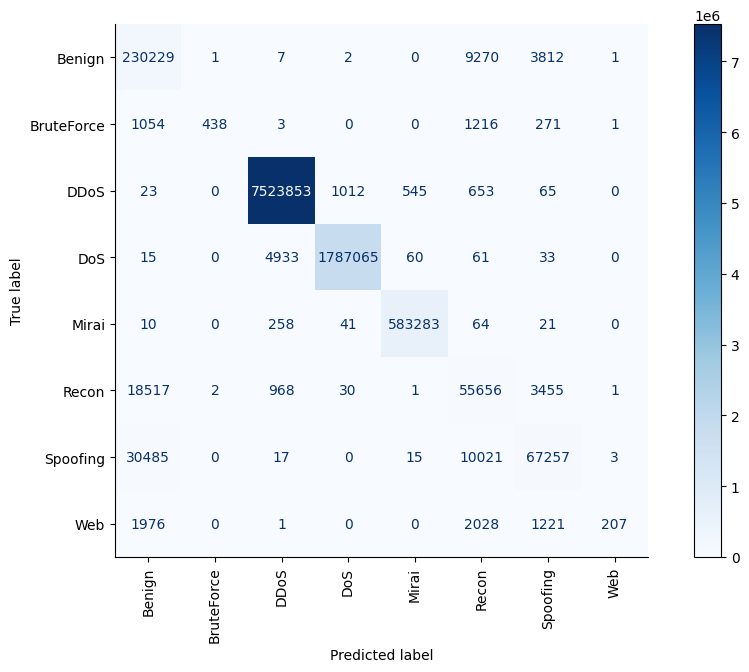

In [5]:
paper_confusion_matrix = pd.DataFrame.from_dict({
    'Benign': [230229,1,7,2,0,9270,3812,1],
    'BruteForce': [1054,438,3,0,0,1216,271,1],
    'DDoS': [23,0,7523853,1012,545,653,65,0],
    'DoS': [15,0,4933,1787065,60,61,33,0],
    'Mirai': [10,0,258,41,583283,64,21,0],
    'Recon': [18517,2,968,30,1,55656,3455,1],
    'Spoofing': [30485,0,17,0,15,10021,67257,3],
    'Web': [1976,0,1,0,0,2028,1221,207],
}, orient='index')

model_utils.show_metrics(
    paper_confusion_matrix.values,
    labels=paper_confusion_matrix.index
)

In [6]:
display(HTML(f"""
<p>
    Interesting to notice that in the paper, the authors mention that they have used a <strong>80/20 split</strong>,
    but based on the length of the dataset released and the absolute values in the Confusion Matrix, 
    we see a slightly different distribution, with the Test data having 
    <strong>{paper_confusion_matrix.sum().sum() / len(df):.2%}</strong> of the data.
</p>
"""))

# Baseline

In [7]:
%%time

is_attack = (df.general_label != 'Benign').map({
    True: 'Attack',
    False: 'Benign'
}).astype('category')

binary_baseline_df_split = model_utils.get_train_test_split(
    df,
    target=is_attack,
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).
CPU times: user 1min 6s, sys: 5.76 s, total: 1min 12s
Wall time: 1min 12s


In [ ]:
%%time

binary_baseline_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = binary_baseline_df_split

model_utils.train_model(
    binary_baseline_model,
    X_train,
    y_train,
    save_name='binary_baseline_random_forest'
)

# Nodes: 28121672
Execution time (Predict): 0:00:28.104657
              precision    recall  f1-score   support

      Benign     0.9256    0.9811    0.9526    219545
  BruteForce     0.9960    0.5655    0.7214      2656
        DDoS     0.9999    1.0000    0.9999   6797400
         DoS     0.9999    0.9999    0.9999   1617348
       Mirai     1.0000    1.0000    1.0000    526792
       Recon     0.9112    0.8468    0.8778     70864
    Spoofing     0.9208    0.8777    0.8987     97575
         Web     0.9797    0.4521    0.6187      5136

    accuracy                         0.9966   9337316
   macro avg     0.9666    0.8404    0.8836   9337316
weighted avg     0.9966    0.9966    0.9966   9337316

CPU times: user 6min 35s, sys: 37 s, total: 7min 12s
Wall time: 1min 36s


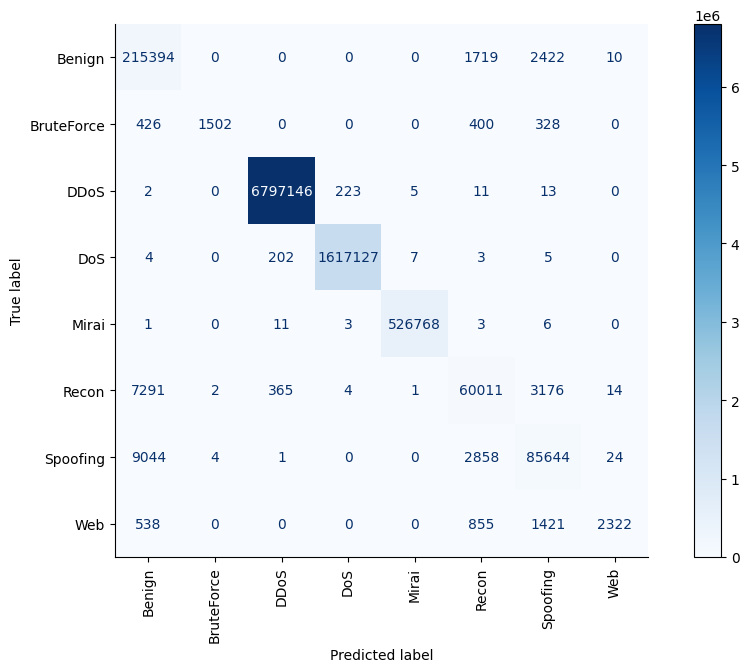

In [11]:
%%time
binary_baseline_model = model_utils.model_load('binary_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in binary_baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = binary_baseline_df_split
model_utils.evaluate_model(binary_baseline_model, X_test, y_test)

## 7+1 Attacks

In [12]:
simplified_baseline_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [6]:
%%time

simplified_baseline_model = RandomForestClassifier(n_jobs=n_jobs, random_state=seed)

X_train, X_test, y_train, y_test = simplified_baseline_df_split

model_utils.train_model(
    simplified_baseline_model,
    X_train,
    y_train,
    save_name='simplified_baseline_random_forest'
)

Execution time (Model fit): 0:17:34.903705
CPU times: user 6h 54min 10s, sys: 4min 17s, total: 6h 58min 27s
Wall time: 17min 39s


RandomForestClassifier(n_jobs=30, random_state=6958)

Loading model 'simplified_baseline_random_forest' (3.35 GB)
# Nodes: 28121672
Execution time (Predict): 0:00:28.847492
              precision    recall  f1-score   support

      Benign     0.9256    0.9811    0.9526    219545
  BruteForce     0.9960    0.5655    0.7214      2656
        DDoS     0.9999    1.0000    0.9999   6797400
         DoS     0.9999    0.9999    0.9999   1617348
       Mirai     1.0000    1.0000    1.0000    526792
       Recon     0.9112    0.8468    0.8778     70864
    Spoofing     0.9208    0.8777    0.8987     97575
         Web     0.9797    0.4521    0.6187      5136

    accuracy                         0.9966   9337316
   macro avg     0.9666    0.8404    0.8836   9337316
weighted avg     0.9966    0.9966    0.9966   9337316

CPU times: user 6min 29s, sys: 36.9 s, total: 7min 6s
Wall time: 1min 37s


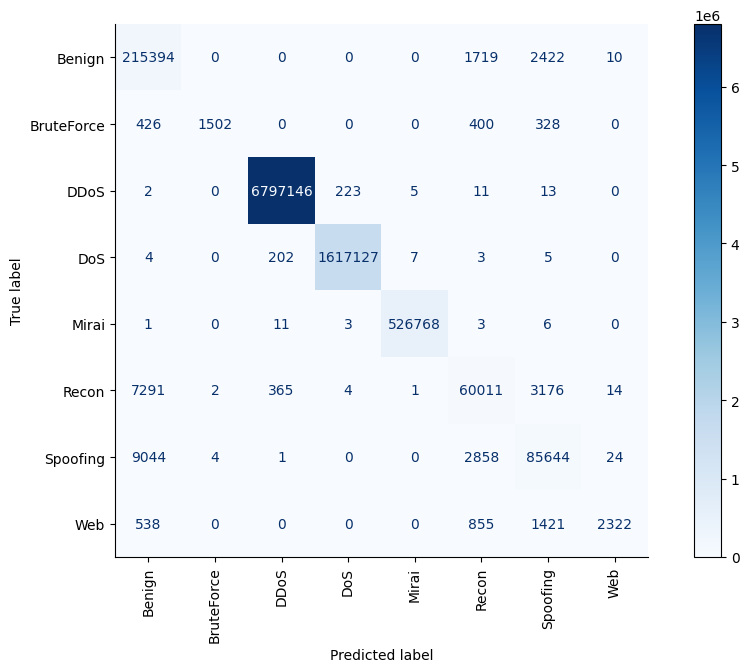

In [34]:
%%time
simplified_baseline_model = model_utils.model_load('simplified_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in simplified_baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = simplified_baseline_df_split
model_utils.evaluate_model(simplified_baseline_model, X_test, y_test)

## 33+1 Attacks

In [20]:
baseline_df_split = model_utils.get_train_test_split(
    df,
    target='label',
    train_frac=0.80
)

Training dataset size: 37.3M (80.0%).
Test dataset size: 9.3M (20.0%).


In [9]:
%%time

baseline_model = RandomForestClassifier(n_jobs=n_jobs, random_state=seed)

X_train, X_test, y_train, y_test = baseline_df_split

model_utils.train_model(
    baseline_model,
    X_train,
    y_train,
    save_name='baseline_random_forest'
)

Execution time (Model fit): 0:18:56.548947
CPU times: user 6h 55min 21s, sys: 4min 42s, total: 7h 3s
Wall time: 19min 49s


RandomForestClassifier(n_jobs=30, random_state=6958)

Loading model 'baseline_random_forest' (14.07 GB)
# Nodes: 44948822
Execution time (Predict): 0:01:37.966687
                         precision    recall  f1-score   support

       Backdoor_Malware     0.9337    0.2534    0.3986       667
          BenignTraffic     0.9073    0.9888    0.9463    219545
       BrowserHijacking     0.9644    0.4089    0.5743      1191
       CommandInjection     0.8542    0.4411    0.5818      1129
 DDoS-ACK_Fragmentation     0.9973    0.9981    0.9977     57361
        DDoS-HTTP_Flood     0.9948    0.9903    0.9925      5771
        DDoS-ICMP_Flood     0.9999    0.9999    0.9999   1439718
DDoS-ICMP_Fragmentation     0.9975    0.9994    0.9985     90845
      DDoS-PSHACK_Flood     0.9999    0.9998    0.9999    819425
       DDoS-RSTFINFlood     0.9999    0.9997    0.9998    808659
         DDoS-SYN_Flood     0.9998    0.9997    0.9998    811376
         DDoS-SlowLoris     0.9681    0.9939    0.9808      4740
DDoS-SynonymousIP_Flood     0.9998    0.9997 

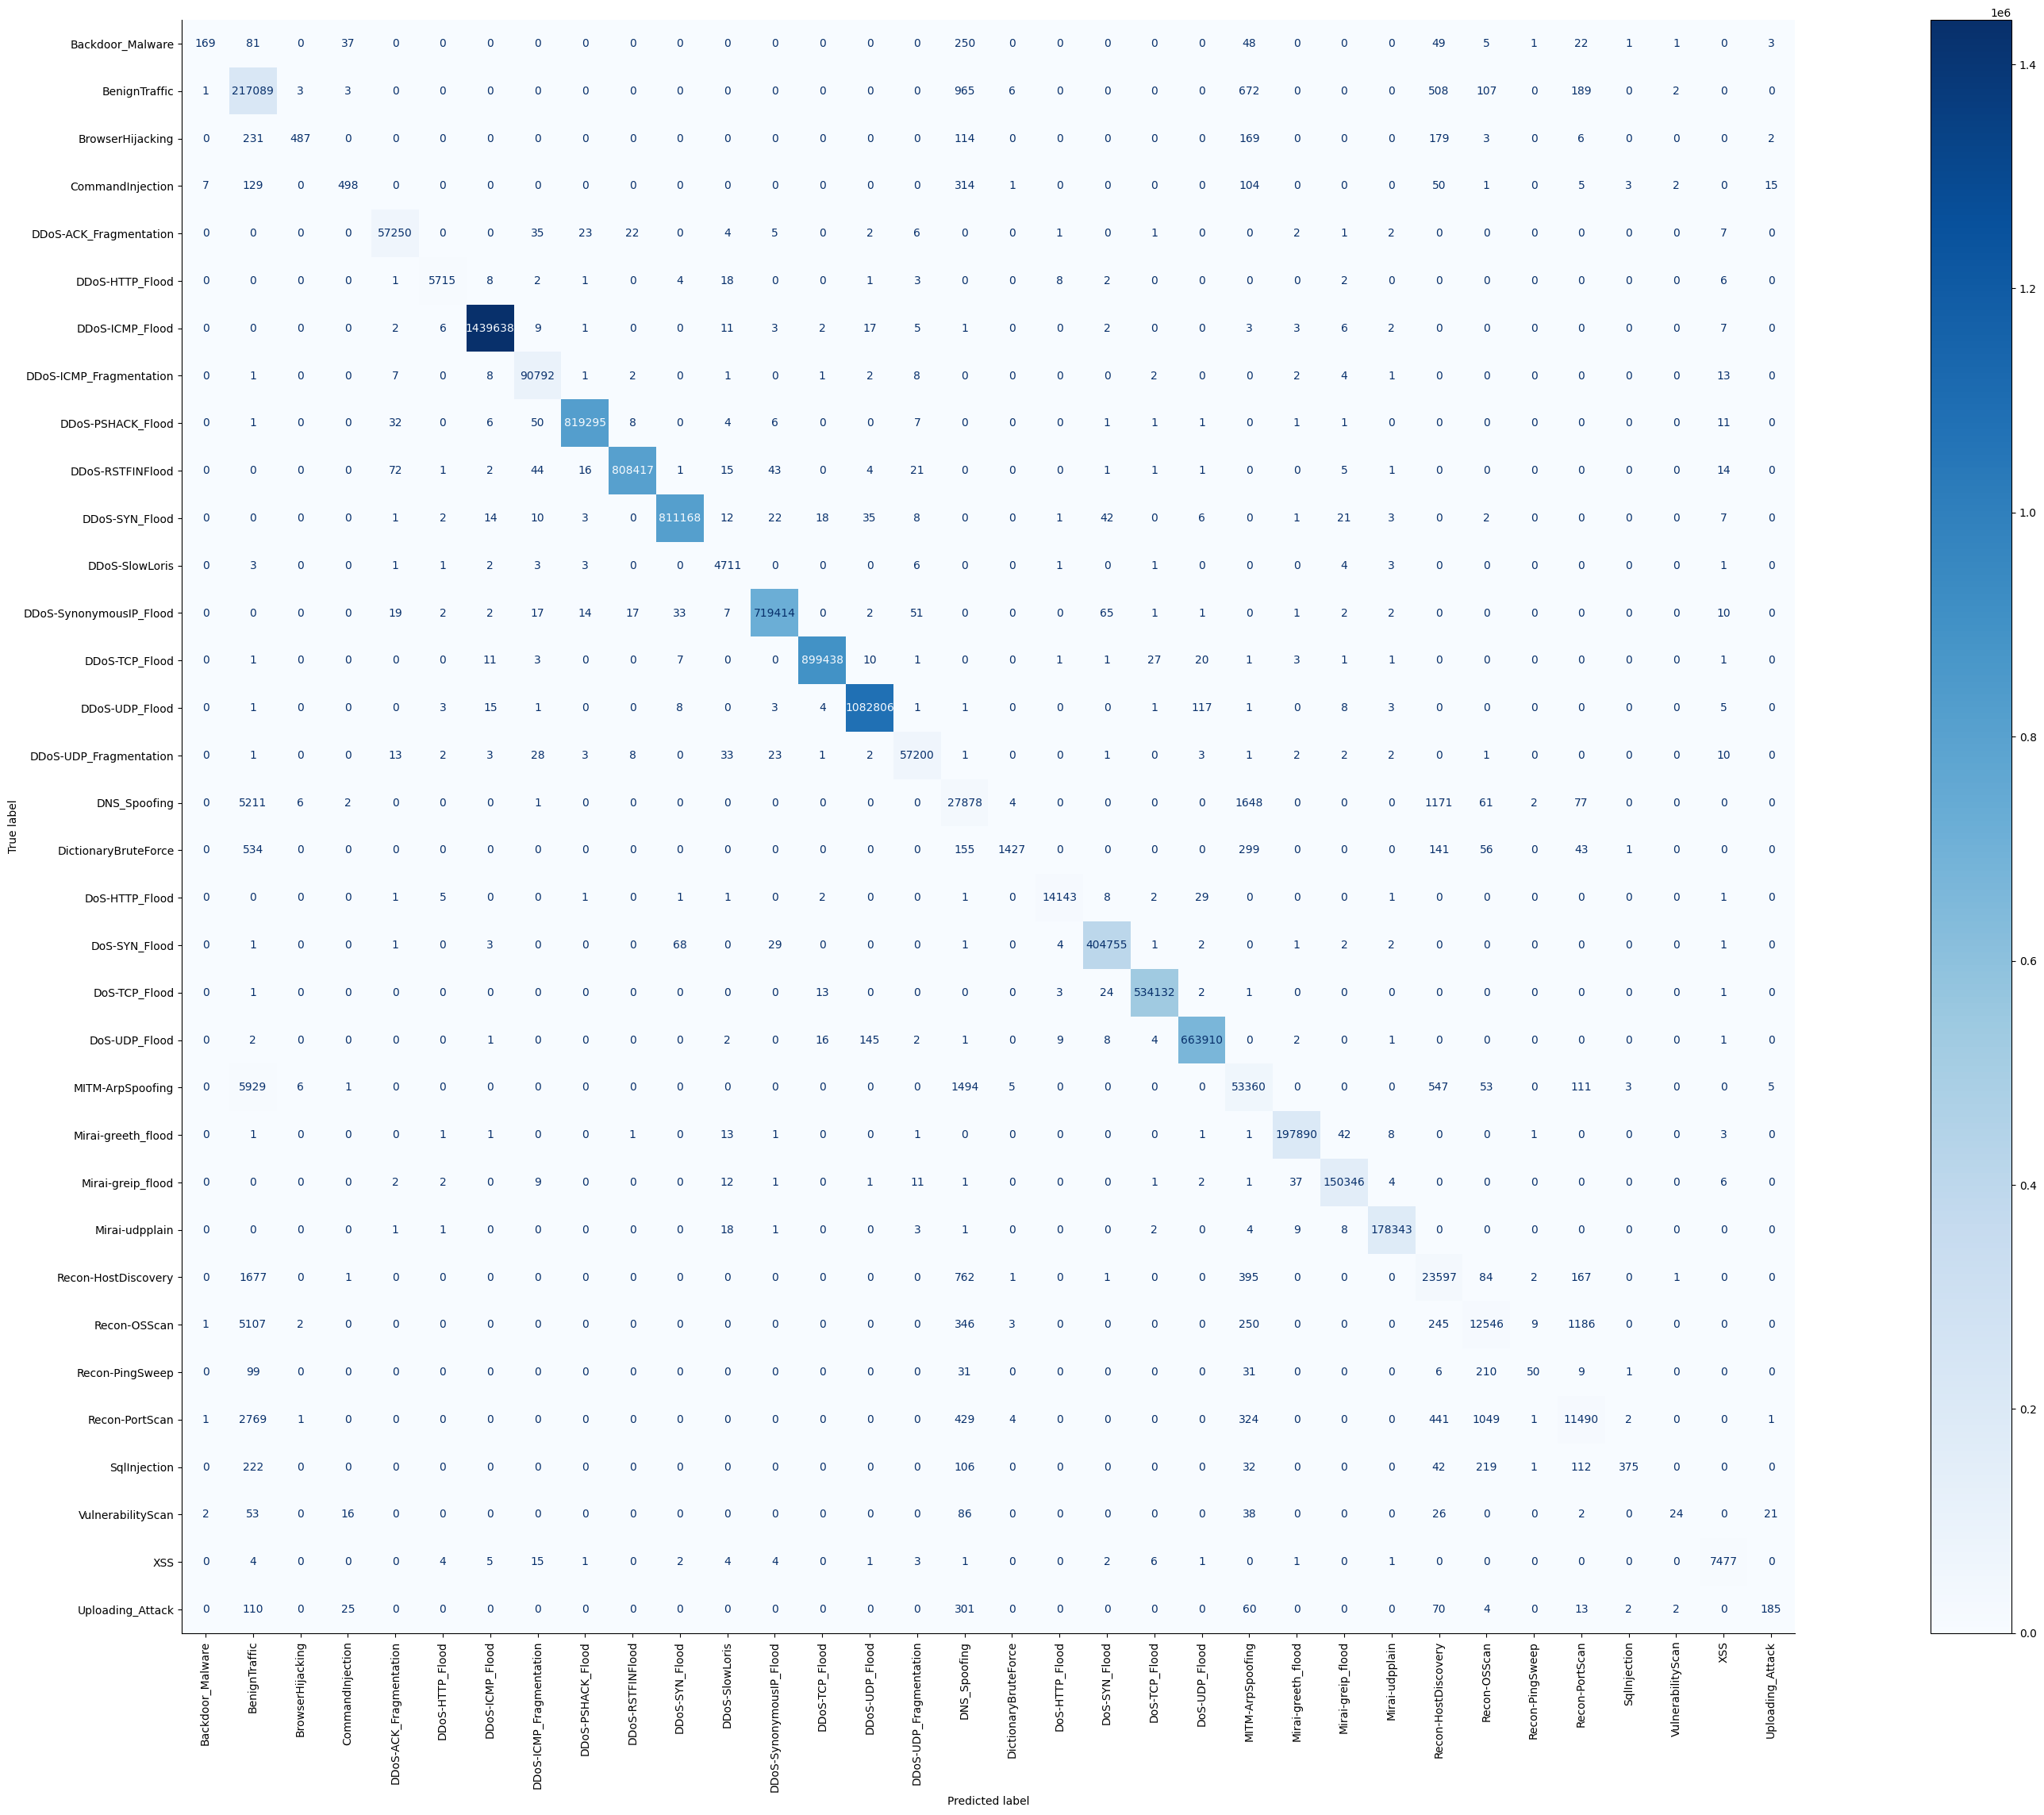

In [33]:
%%time
baseline_model = model_utils.model_load('baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = baseline_df_split
model_utils.evaluate_model(baseline_model, X_test, y_test)

# Optimized Baseline

## Binary Classification - Attack / Benign flow

## 33+1 Attacks

In [10]:
%%time

opt_baseline_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_features=12,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = opt_baseline_df_split

model_utils.train_model(
    opt_baseline_model,
    df_train[refined_features_list],
    df_train['label'],
    save_name='opt_baseline_random_forest'
)

NameError: name 'opt_baseline_df_split' is not defined

In [11]:
%%time
opt_baseline_model = model_utils.model_load('opt_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in opt_baseline_model.estimators_)}")

X_train, X_test, y_train, y_test = opt_baseline_df_split
model_utils.evaluate_model(opt_baseline_model, X_test, y_test)

Loading model 'opt_baseline_random_forest' (7.87 GB)



KeyboardInterrupt



## 7+1 Attacks

In [ ]:
%%time

simplified_opt_baseline_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_features=12,
    n_jobs=n_jobs,
    random_state=seed
)

model_utils.train_model(
    simplified_opt_baseline_model,
    df_train[refined_features_list],
    df_train['general_label'],
    save_name='simplified_opt_baseline_random_forest'
)

In [ ]:
%%time
simplified_opt_baseline_model = model_utils.model_load('simplified_opt_baseline_random_forest')

print(f"# Nodes: {sum(tree.tree_.node_count for tree in simplified_opt_baseline_model.estimators_)}")

model_utils.evaluate_model(simplified_opt_baseline_model, df_test[refined_features_list], df_test['general_label'])

# Multi-Stage Model

In [8]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## 7+1 Attacks

In [15]:
%%time

simplified_multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=DecisionTreeClassifier(
                class_weight='balanced',
                criterion='entropy',
                min_samples_split=5,
                random_state=seed
            ),
            labels=simplified_first_layer_labels
        ),
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                bootstrap=False,
                max_features=14,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=simplified_second_layer_labels
        ),
    ]
)

model_utils.train_model(
    simplified_multi_stage_model,
    df_train[refined_features_list],
    df_train['general_label'],
    save_name='simplified_multi_stage_model'
)

Execution time (Model fit): 0:18:50.293540
CPU times: user 1h 56min 14s, sys: 20.5 s, total: 1h 56min 35s
Wall time: 19min 2s


MultiStageClassifier(stages=[ModelStage(model=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=5, random_state=6958), labels={'DoS', 'DDoS', 'Mirai'}),
                             ModelStage(model=RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_features=14, n_jobs=20,
                       random_state=6958), labels={'Web', 'Spoofing', 'Recon', 'BruteForce'})])

Loading model 'simplified_multi_stage_model' (2.29 GB)
# Nodes (1st stage): 3489
# Nodes (2nd stage): 23604300
Execution time (Predict): 0:00:09.474946
              precision    recall  f1-score   support

      Benign     0.9343    0.9812    0.9572    219545
  BruteForce     0.9538    0.6367    0.7636      2656
        DDoS     1.0000    1.0000    1.0000   6797400
         DoS     0.9998    0.9998    0.9998   1617348
       Mirai     0.9999    1.0000    1.0000    526792
       Recon     0.9176    0.8703    0.8933     70864
    Spoofing     0.9333    0.8892    0.9107     97575
         Web     0.9484    0.6044    0.7383      5136

    accuracy                         0.9970   9337316
   macro avg     0.9609    0.8727    0.9079   9337316
weighted avg     0.9970    0.9970    0.9970   9337316

CPU times: user 1min 27s, sys: 6.69 s, total: 1min 33s
Wall time: 1min 20s


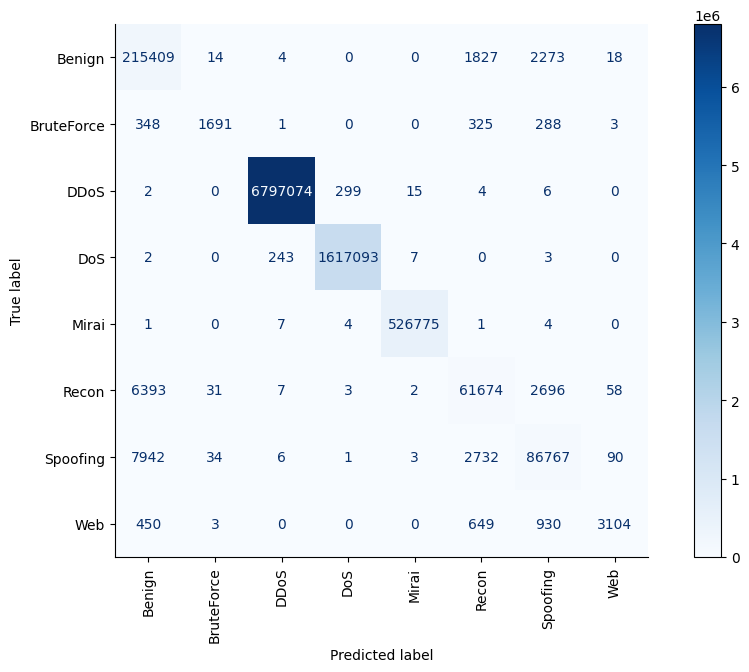

In [16]:
%%time
multi_stage_baseline_model = model_utils.model_load('simplified_multi_stage_model')

print(f"# Nodes (1st stage): {multi_stage_baseline_model.stages[0].model.tree_.node_count}")
print(f"# Nodes (2nd stage): {sum(tree.tree_.node_count for tree in multi_stage_baseline_model.stages[1].model.estimators_)}")

model_utils.evaluate_model(multi_stage_baseline_model, df_test[refined_features_list], df_test['general_label'])

## 33+1 attacks

In [12]:
%%time

multi_stage_model = MultiStageClassifier(
    default_label='BenignTraffic',
    stages=[
        ModelStage(
            model=DecisionTreeClassifier(
                class_weight='balanced',
                criterion='entropy',
                min_samples_split=5,
                random_state=seed
            ),
            labels=first_layer_labels
        ),
        ModelStage(
            model=RandomForestClassifier(
                class_weight='balanced',
                criterion='entropy',
                bootstrap=False,
                max_features=14,
                n_jobs=n_jobs,
                random_state=seed
            ),
            labels=second_layer_labels
        ),
    ]
)

model_utils.train_model(
    multi_stage_model,
    df_train[refined_features_list],
    df_train['label'],
    save_name='multi_stage_model'
)

Execution time (Model fit): 0:22:16.402452
CPU times: user 2h 33min 26s, sys: 26.5 s, total: 2h 33min 52s
Wall time: 22min 42s


MultiStageClassifier(default_label='BenignTraffic',
                     stages=[ModelStage(model=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_split=5, random_state=6958), labels={'DDoS-HTTP_Flood', 'DoS-SYN_Flood', 'DDoS-ICMP_Flood', 'DDoS-SlowLoris', 'DDoS-ICMP_Fragmentation', 'Mirai-udpplain', 'Mirai-greip_flood', 'DoS-TCP_Flood', 'DDoS-Synony...
                             ModelStage(model=RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_features=14, n_jobs=20,
                       random_state=6958), labels={'DictionaryBruteForce', 'MITM-ArpSpoofing', 'Recon-OSScan', 'DNS_Spoofing', 'Recon-PortScan', 'Recon-PingSweep', 'CommandInjection', 'Recon-HostDiscovery', 'Uploading_Attack', 'SqlInjection', 'Backdoor_Malware', 'XSS', 'VulnerabilityScan', 'BrowserHijacking'})])

Loading model 'multi_stage_model' (5.38 GB)
# Nodes (1st stage): 4939
# Nodes (2nd stage): 31362600
Execution time (Predict): 0:00:13.000967
                         precision    recall  f1-score   support

       Backdoor_Malware     0.8850    0.5652    0.6898       667
          BenignTraffic     0.9154    0.9886    0.9506    219545
       BrowserHijacking     0.9592    0.6322    0.7621      1191
       CommandInjection     0.9503    0.6439    0.7677      1129
 DDoS-ACK_Fragmentation     0.9998    0.9999    0.9999     57361
        DDoS-HTTP_Flood     0.9984    0.9986    0.9985      5771
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000   1439718
DDoS-ICMP_Fragmentation     0.9998    0.9998    0.9998     90845
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    819425
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    808659
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    811376
         DDoS-SlowLoris     0.9973    0.9981    0.9977      4740
DDoS-Synonymo

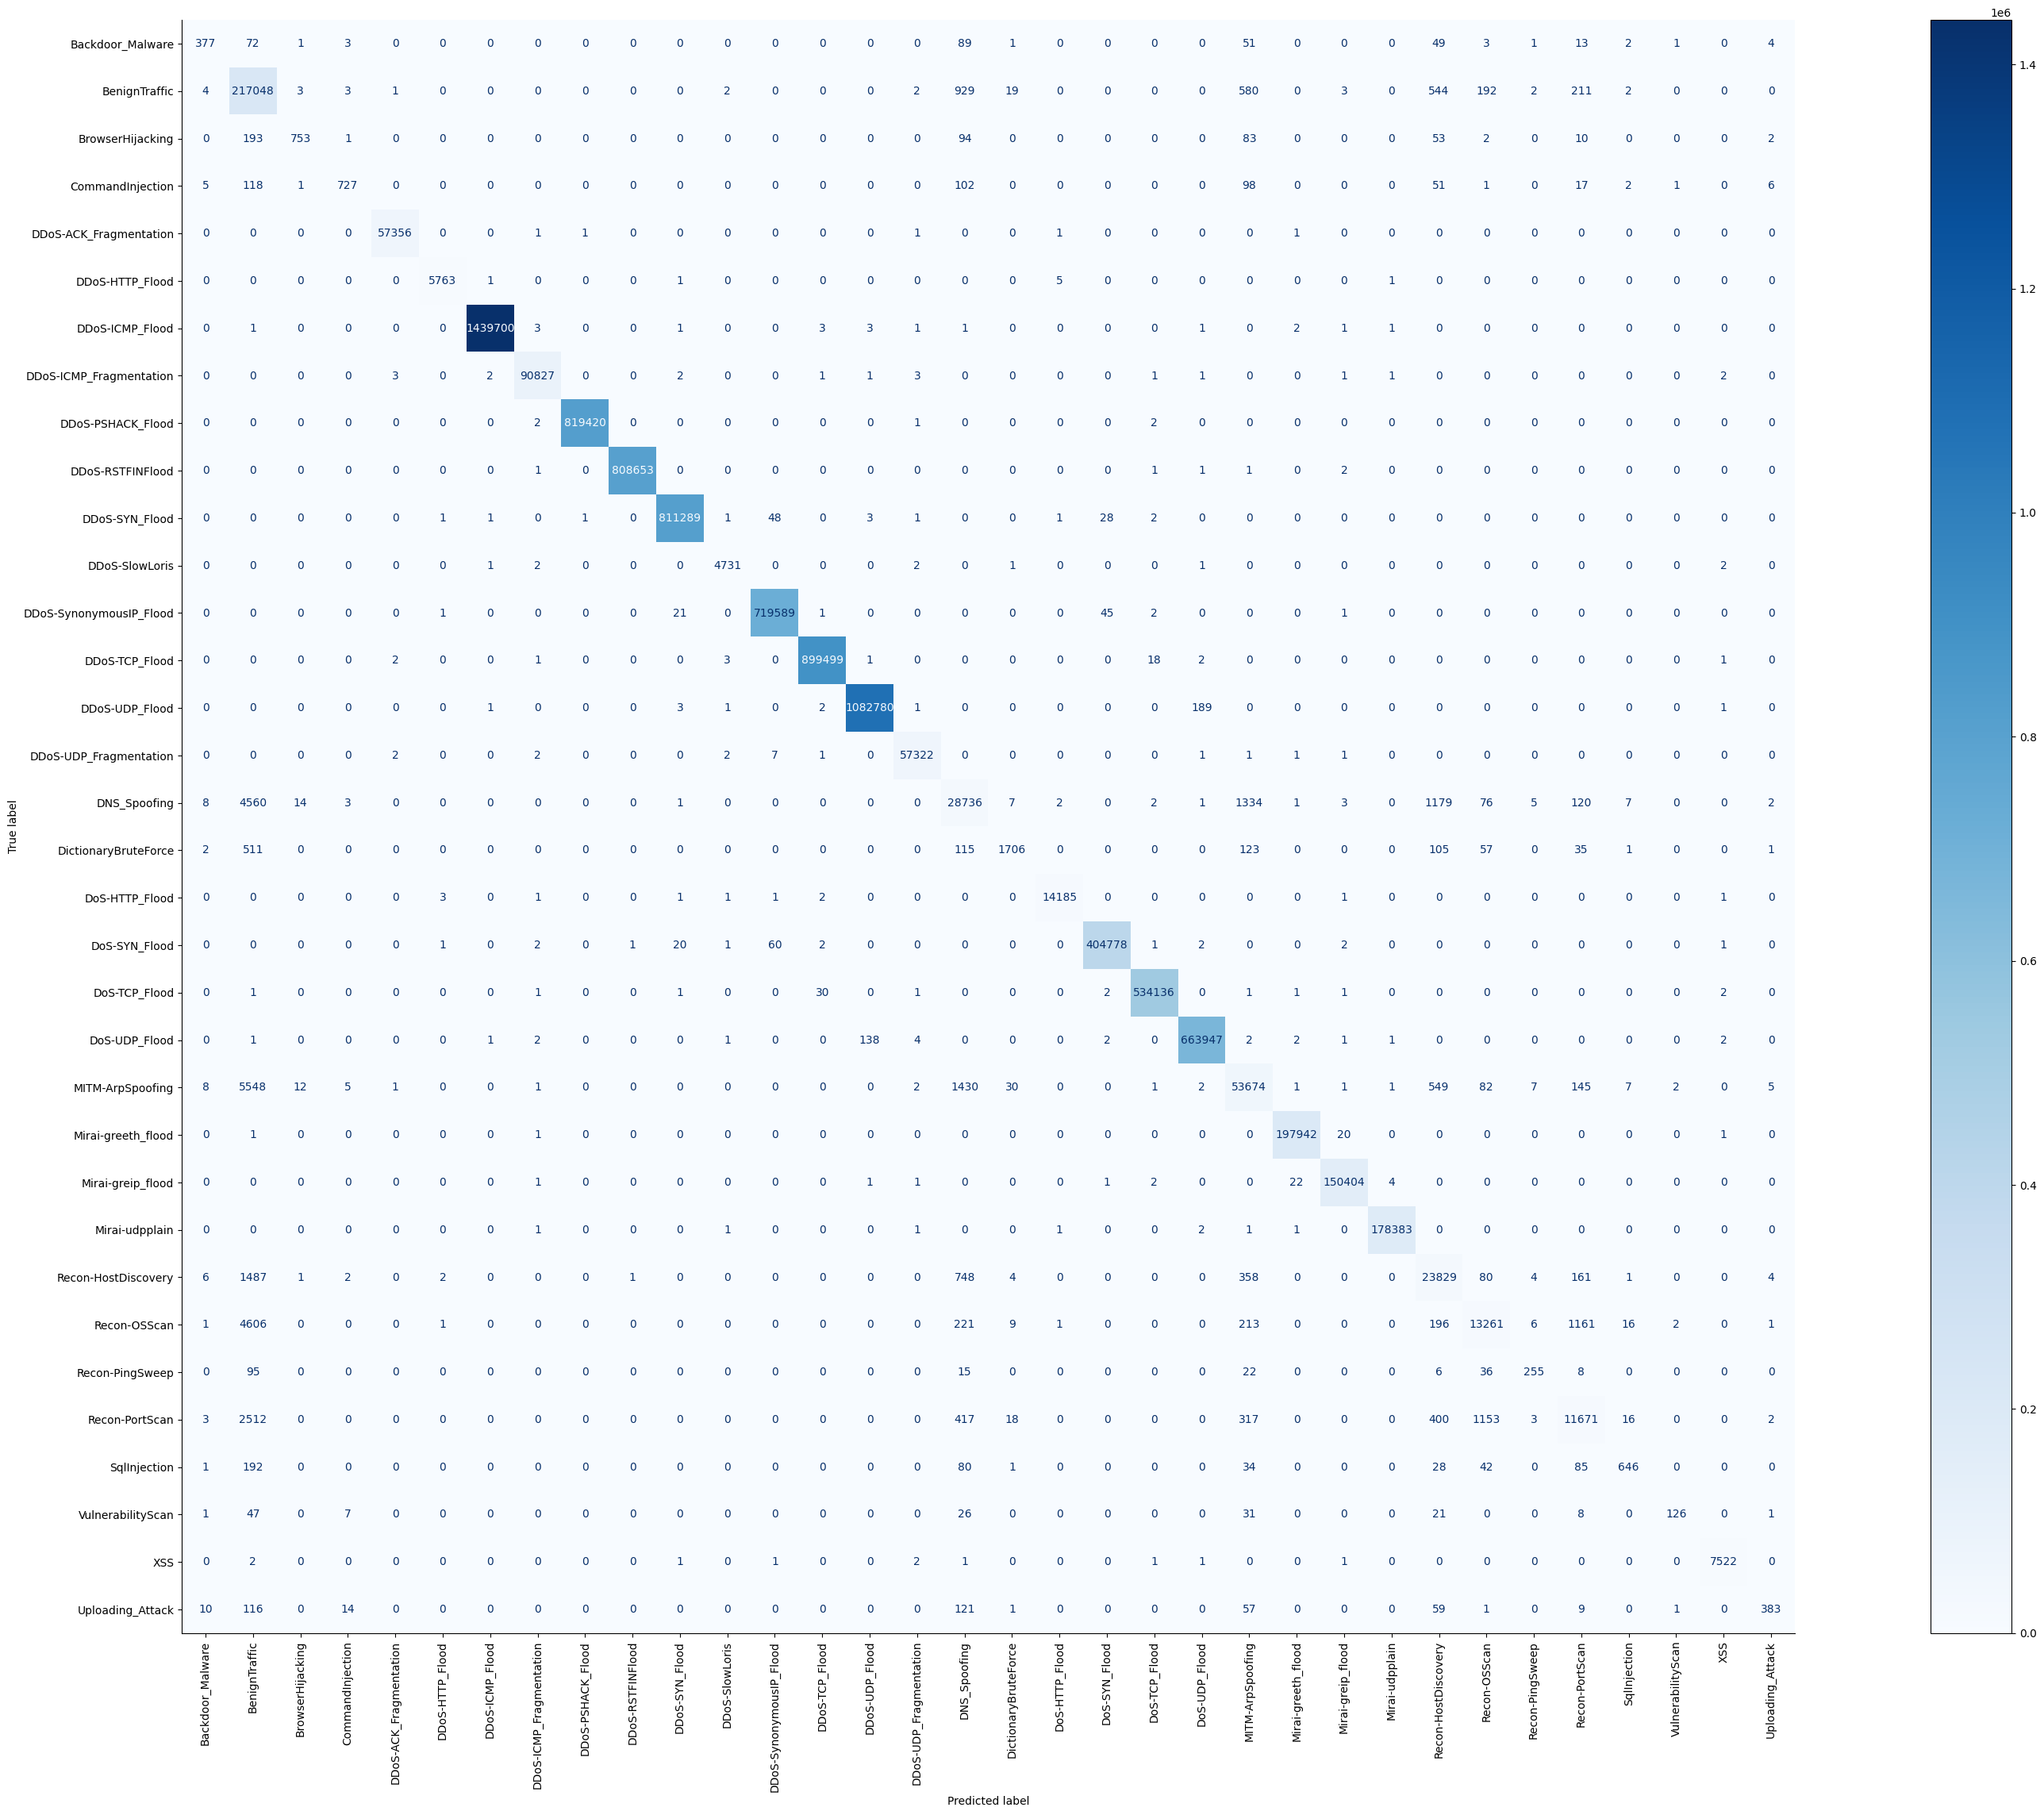

In [13]:
%%time
multi_stage_model = model_utils.model_load('multi_stage_model')

print(f"# Nodes (1st stage): {multi_stage_model.stages[0].model.tree_.node_count}")
print(f"# Nodes (2nd stage): {sum(tree.tree_.node_count for tree in multi_stage_model.stages[1].model.estimators_)}")

model_utils.evaluate_model(multi_stage_model, df_test[refined_features_list], df_test['label'])